# План проекта

1. Описание проекта
2. Загрузка и ознакомление с данными
3. Предобработка данных и их анализ
    - Объединение данных
    - Проверка корреляции
    - Отбор признаков
    - Выделение целевого признака
    - Исследовательский анализ данных
    - Преобразование категориальных признаков
4. Обучение моделей
    - Разбиение на тренировочную и тестовую выборку
    - Обучение различных моделей (LogisticRegression, RandomForest, Catboost)
    - Выделение лучшей модели по таким метрикам, как ROC-AUC и accuracy
5. Тестирование выбранной модели на тестовой выборке
    - Проверка модели
    - Анализ важности признаков
6. Отчет

# Введение

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Нам необходимо разработать модель, которая будет предсказывать уход клиента.

In [60]:
import  warnings
warnings.filterwarnings('ignore')

# подключим необходимые библиотеки
import pandas as pd
import phik
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

STATE = 60623

# Загрузка и изучение данных

In [61]:
# Загрузим данные
try:
    contract = pd.read_csv('datasets/contract_new.csv')
    internet = pd.read_csv('datasets/internet_new.csv')
    personal = pd.read_csv('datasets/personal_new.csv')
    phone = pd.read_csv('datasets/phone_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')


## Данные о договоре

In [62]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


В столбце EndDate есть даты и "No", соответсвенно No означает, что клиент остался, а дата указывает на факт ухода. Данный столбец нужно будет обработать.

In [63]:
contract.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,6311-UEUME,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [64]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [65]:
contract['TotalCharges'].value_counts()

           11
20.45       6
101.0       5
40.1        4
255.0       4
           ..
2886.0      1
624.0       1
1482.95     1
8145.0      1
1684.7      1
Name: TotalCharges, Length: 6658, dtype: int64

В столбце TotalCharges есть 11 пустых значений. Посмотрим только на эти данные.

In [66]:
contract.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Дата начала действия договора совпадает с датой выгрузки данных, из-за этого столбец TotalCharges для этих клиентов пустой. Данные пропуски нужно будет заменить на значения из MontlyCharges.

Мы видим, что пропусков и дубликатов нет.
Также необходимо поменять тип данных в столбцах BeginDate и EndDate.

## Персональные данные клиента

In [67]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [68]:
personal.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,6311-UEUME,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [69]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [70]:
columns = ['gender', 'Partner', 'Dependents']
for column in columns:
    print(personal[column].value_counts())
    print()

Male      3555
Female    3488
Name: gender, dtype: int64

No     3641
Yes    3402
Name: Partner, dtype: int64

No     4933
Yes    2110
Name: Dependents, dtype: int64



Мы видим, что количество строк такое же, как и в датасете с информацией по контрактам.
Также нет пропусков и дубликатов, при этом имеется 3 категориальных признака, которые необходимо преобразовать.

## Информация об интернет-услугах

In [71]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [72]:
internet.describe(include='all')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,8660-BUETV,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [73]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Здесь также нет пропусков и дубликатов, при этом строк меньше, чем в предыдущих датасетах. Это может быть связано с тем, что некоторые пользователи пользуются только интернетом, без телефона.
Также видно, что все признаки категориальные, их необходимо преобразовать

## Информация об услугах телефонии

In [74]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [75]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Видно, что пропусков и дубликатов нет.
Есть один котегориальный признак, который также необходимо преобразовать.
Также данных здесь меньше, чем данных по контрактам, из-за того, что есть люди, которые пользуются только телефонией.

Также для дальнейшей работы необходимо объединить все данные в один датасет.

# Предобработка данных и их анализ

## Предобработка данных

In [76]:
# Объединим данные в один датасет
df = contract.merge(personal, how='left', on='customerID').merge(phone, how='left', on='customerID').merge(internet, how='left', on='customerID')
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,Male,0,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,Female,0,Yes,Yes,NaN,DSL,Yes,No,No,No,No,No
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8,Male,1,Yes,No,Yes,Fiber optic,No,No,No,No,No,No


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


Появившиеся пропуски можно заменить на No, т.к. этими услугами пользователи не пользуются.

In [78]:
df.fillna('No', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 non-null   object 


Теперь поработаем с неявными пропусками в столбце totalcharges. Их можно заменить на значения из столбца monthlycharges.

In [79]:
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = 0
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [80]:
# установим customerid в качестве индекса
df = df.set_index('customerID')

Посмотрим на столбец с датами окончания договора

In [81]:
print(df['EndDate'].value_counts())

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-09-01       2
2014-10-01       1
2014-06-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64


Значения No означают, что клиент остался, отсюда выделим целевой признак и назовем его target. В дальнейшем эти значения можно заменить на дату выгрузки данных.

In [82]:
def target(data):
    if data == 'No':
        return 0
    else:
        return 1
df['left'] = df['EndDate'].apply(target)
df

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,left
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,Yes,No,DSL,Yes,No,No,No,No,No,0


In [83]:
df['EndDate'].replace('No', '2020-02-01', inplace=True)

# приведем столбцы с датами в формат дат
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  MultipleLines     7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup  

Добавим дополнительный признак, который будет показывать количество дней от начала действия договора до его конца

In [84]:
df['days'] = (df['EndDate'] - df['BeginDate']).dt.days
df

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,left,days
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,DSL,No,Yes,No,No,No,No,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,No,DSL,Yes,No,Yes,No,No,No,0,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,No,DSL,Yes,Yes,No,No,No,No,0,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,No,DSL,Yes,No,Yes,Yes,No,No,0,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,Fiber optic,No,No,No,No,No,No,0,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,...,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0,730
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,2191
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,...,No,DSL,Yes,No,No,No,No,No,0,337


Также удалим столбцы begindate и enddate, т.к. они теперь не несут важной информации для обучения моделей.

In [85]:
del df['BeginDate']
del df['EndDate']

Предобработка данных завершена. Теперь приступим к анализу данных.

## Анализ данных

Построим корреляционную матрицу

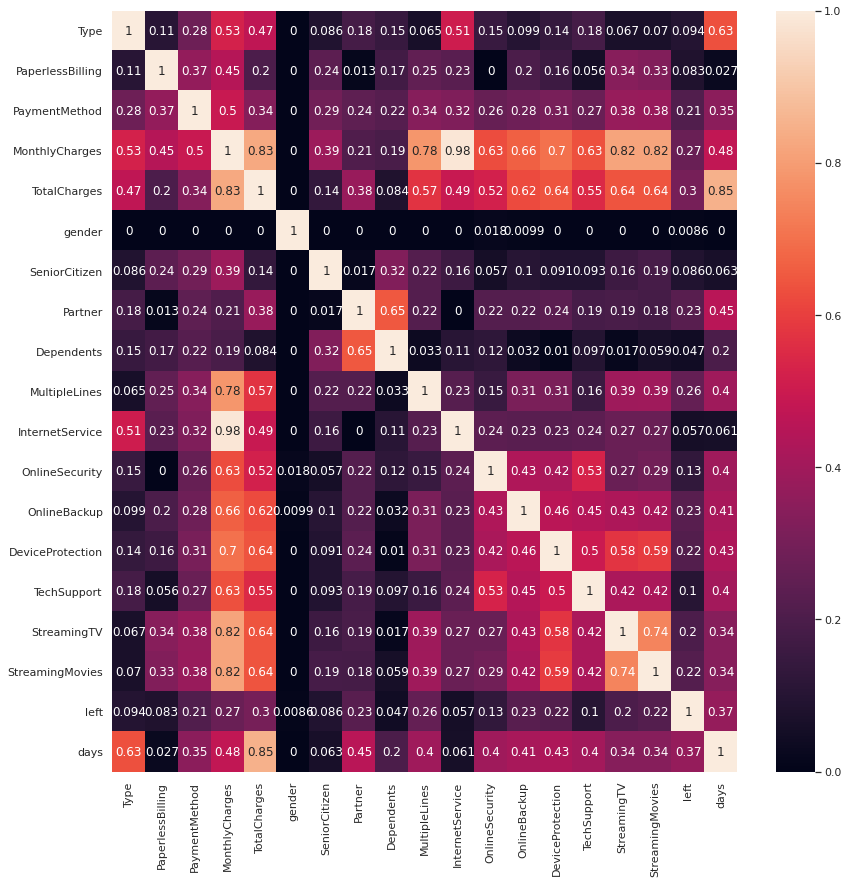

In [86]:
plt.figure(figsize=(14,14))
sns.heatmap(df.phik_matrix(interval_cols=['TotalCharges', 'days']), annot=True)

plt.show()

Мы видим, что пол практически не коррелирует ни с одним из признаков, значит можно считать, что он статистически не значим.
Также есть сильная корреляция между Monthly Charges и Total Charges, при этом Total Chatrges больше коррелирует с целевым признаком.
Таким образом нам нужно убрать из датасета столбцы gender и monthly charges.

In [87]:
del df['MonthlyCharges']
del df['gender']
del df['StreamingTV']

Посмотрим на распределение MonthlyCharges у людей, которые остались, и тех, кто ушел

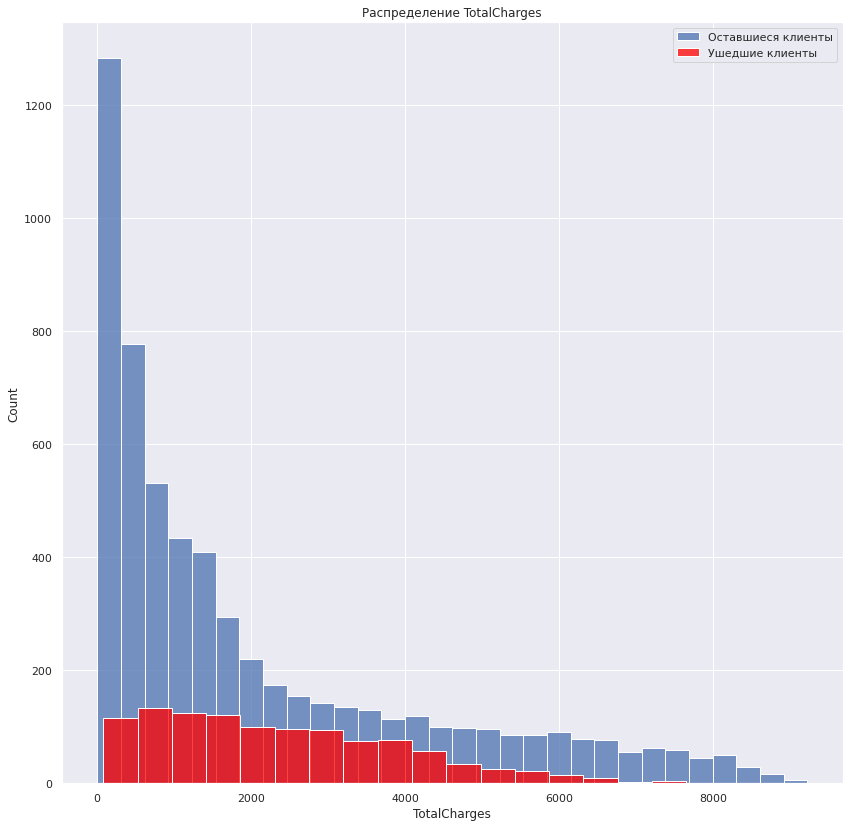

In [88]:
sns.histplot(data=df.loc[df['left'] == 0, 'TotalCharges'], label='Оставшиеся клиенты').legend()
sns.histplot(data=df.loc[df['left'] == 1, 'TotalCharges'], label='Ушедшие клиенты', color='red').legend()
plt.title('Распределение TotalCharges')
plt.show()

Распределения примерно одинаковые, но наблюдается большое количество клиентов, у которых суммарные затраты в районе 0. Скорее всего это связано с тем, что новых клиентов достаточно много.

Посмотрим на распределение времени обслуживания у этих же групп

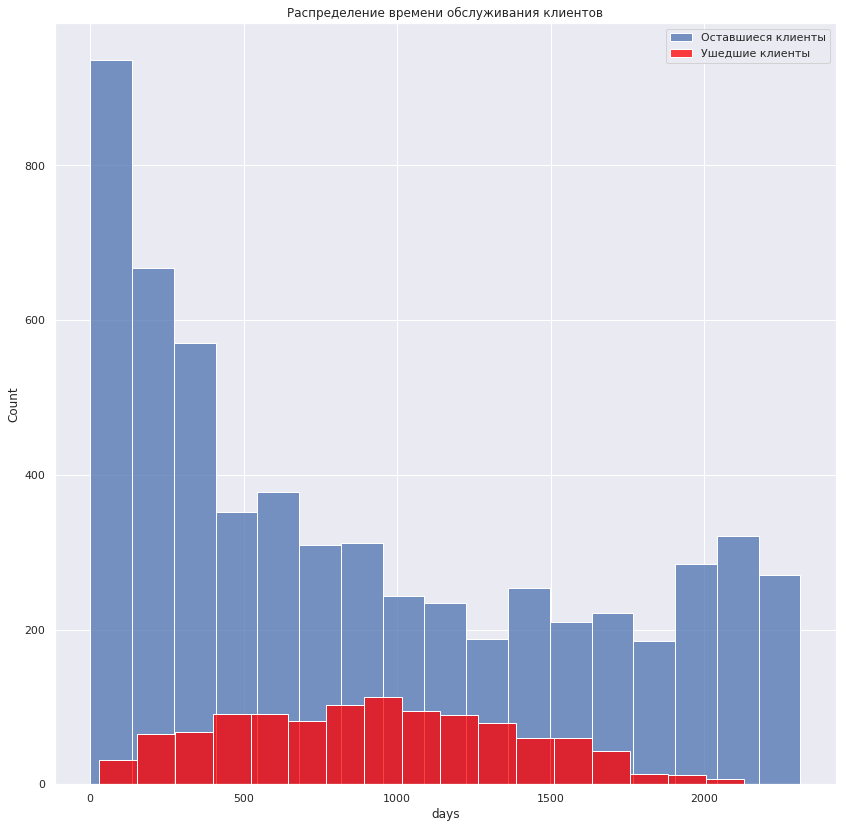

In [89]:
sns.histplot(data=df.loc[df['left'] == 0, 'days'], label='Оставшиеся клиенты').legend()
sns.histplot(data=df.loc[df['left'] == 1, 'days'], label='Ушедшие клиенты', color='red').legend()
plt.title('Распределение времени обслуживания клиентов')
plt.show()


Посмотрим на медианные значения дней обсулживания клиентов.

In [90]:
med = df.loc[df['left'] == 0, 'days'].median()
left_med = df.loc[df['left'] == 1, 'days'].median()
print(f'Среднее количество дней обслуживания оставшихся клиентов: {med}')
print(f'Среднее количество дней обслуживания ушедших клиентов: {left_med}')

Среднее количество дней обслуживания оставшихся клиентов: 702.0
Среднее количество дней обслуживания ушедших клиентов: 915.0


Получается, что ушедшие клиенты обслуживались дольше. Возможно это связано опять же с большим количеством новых клиентов. Либо старые клиенты просто решили перейти на нового провайдера.

Посмотрим на несколько категориальных признаков, которые хоть немного коррелируют с целевым (в основном у всех признаков корреляция меньше 0.5)

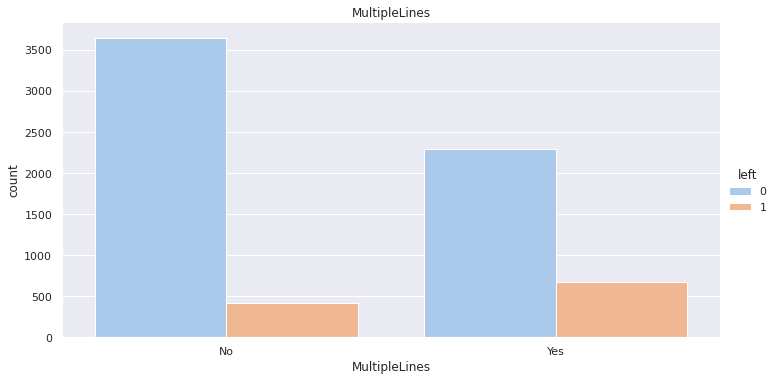

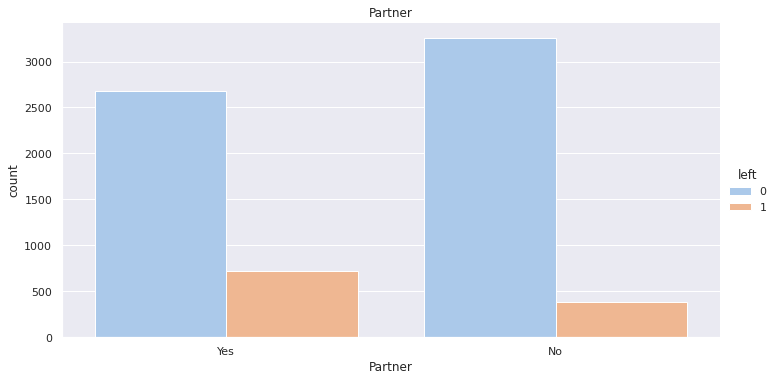

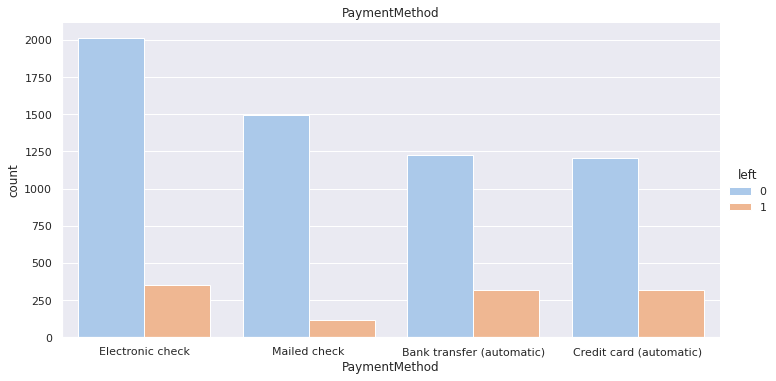

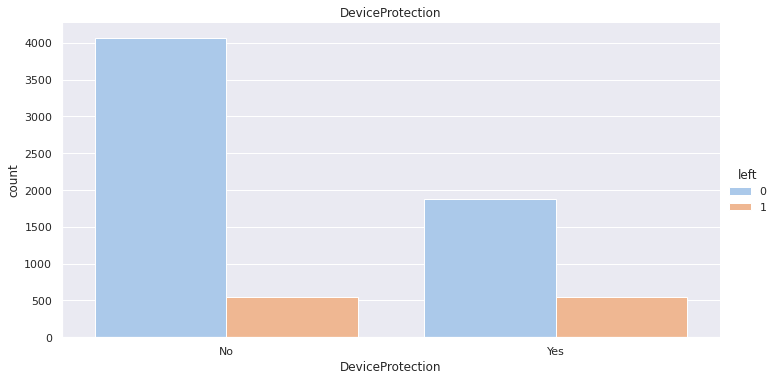

In [91]:
categorical_features = ['MultipleLines', 'Partner', 'PaymentMethod', 'DeviceProtection']

for cat in categorical_features:
    sns.catplot(data=df, x=cat, kind='count', palette='pastel', hue='left', height=5, aspect=2)
    plt.title(cat)
    plt.show()

Видно, что клиентов имеющих и не имеющих супруга примерно одинаковое количество. Также и с клиентами пользующимися несколькими линиями.
Также можно заметить, что клиенты больше предпочитают электронные чеки и чаще не пользуются услугами защиты устройства.

При этом мы можем отметить, что больше ушло клиентов, которые пользовались несколькими линиями, и те, у кого есть супруг(а). Также меньше клиентов ушло, которые получали чек по почте.

Таким образом мы убрали из датасета 2 признака (помесячную оплату и гендер).
Выяснили, что в среднем ушедшие клиенты обслуживались дольше, чем оставшиеся. Больше людей предпочитает оплату электронными чеками, а также редко пользуются услугами защиты устройства.

Разделим датасет на тренировачную и тестовую выборки со стратификацией в соотношении 3 к 1.

In [92]:
# изменим тип SeniorCitizen на object
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [93]:
target = df['left']
features = df.drop(columns='left')

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=STATE, stratify=target)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 2788-CJQAQ to 3519-ZKXGG
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   TotalCharges      5282 non-null   float64
 4   SeniorCitizen     5282 non-null   object 
 5   Partner           5282 non-null   object 
 6   Dependents        5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingMovies   5282 non-null   object 
 14  days              5282 non-null   int64  
dtypes: float64(1), int64(1), object(13)
memory usage: 660.2+ KB


# Обучение моделей

Выделим категориальные и числовые признаки.  
Далее преобразуем их.  
При обучении CatBoost применение OHE к категориальным признакам дало результат хуже, чем указание категориальных признаков в самой модели, поэтому я пропустил данное преобразование. Для Logistic Regression и Random Forest нужно будет его применить.

In [94]:
ohe_features = X_train.select_dtypes(include='object').columns.to_list()
num_features = ['days', 'TotalCharges']

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

## Catboost Classifier

In [95]:
cbc = CatBoostClassifier(random_state=STATE, auto_class_weights='Balanced', eval_metric='AUC', cat_features=ohe_features, verbose=3)

cbc_grid = {
    'learning_rate': [.1, .3],
    'max_depth': [3, 4],
    'n_estimators': range(1400, 1700, 100)
}

search = GridSearchCV(cbc, cbc_grid, cv=5, scoring='roc_auc', verbose=3)
search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	total: 58.3ms	remaining: 1m 21s
3:	total: 81.3ms	remaining: 28.4s
6:	total: 108ms	remaining: 21.5s
9:	total: 126ms	remaining: 17.4s
12:	total: 141ms	remaining: 15s
15:	total: 157ms	remaining: 13.6s
18:	total: 176ms	remaining: 12.8s
21:	total: 193ms	remaining: 12.1s
24:	total: 221ms	remaining: 12.2s
27:	total: 237ms	remaining: 11.6s
30:	total: 254ms	remaining: 11.2s
33:	total: 282ms	remaining: 11.3s
36:	total: 301ms	remaining: 11.1s
39:	total: 324ms	remaining: 11s
42:	total: 337ms	remaining: 10.6s
45:	total: 352ms	remaining: 10.4s
48:	total: 378ms	remaining: 10.4s
51:	total: 444ms	remaining: 11.5s
54:	total: 479ms	remaining: 11.7s
57:	total: 499ms	remaining: 11.5s
60:	total: 514ms	remaining: 11.3s
63:	total: 546ms	remaining: 11.4s
66:	total: 573ms	remaining: 11.4s
69:	total: 599ms	remaining: 11.4s
72:	total: 620ms	remaining: 11.3s
75:	total: 635ms	remaining: 11.1s
78:	total: 648ms	remaining: 10.8s
81:	total: 673ms	remaining

## Random Forest Classifier

In [96]:
X_train_oe = X_train.copy()
X_test_oe = X_test.copy()

encoder_oe = OrdinalEncoder()
encoder_oe.fit(X_train_oe[ohe_features])

X_train_oe[ohe_features] = encoder_oe.transform(X_train_oe[ohe_features])
X_test_oe[ohe_features] = encoder_oe.transform(X_test_oe[ohe_features])

In [97]:
rfc = RandomForestClassifier(random_state=STATE, class_weight='balanced')

rfc_params = {
    'n_estimators': np.arange(100, 200, 10),
    'max_depth': np.arange(10, 30, 5),
}

rfc_search = GridSearchCV(rfc, rfc_params, cv=5, scoring='roc_auc', verbose=3)
rfc_search.fit(X_train_oe, y_train)

print(rfc_search.best_params_)
print(rfc_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END .................max_depth=10, n_estimators=100; total time=   0.5s
[CV 2/5] END .................max_depth=10, n_estimators=100; total time=   0.5s
[CV 3/5] END .................max_depth=10, n_estimators=100; total time=   0.5s
[CV 4/5] END .................max_depth=10, n_estimators=100; total time=   0.4s
[CV 5/5] END .................max_depth=10, n_estimators=100; total time=   0.4s
[CV 1/5] END .................max_depth=10, n_estimators=110; total time=   0.5s
[CV 2/5] END .................max_depth=10, n_estimators=110; total time=   0.5s
[CV 3/5] END .................max_depth=10, n_estimators=110; total time=   0.6s
[CV 4/5] END .................max_depth=10, n_estimators=110; total time=   0.6s
[CV 5/5] END .................max_depth=10, n_estimators=110; total time=   0.4s
[CV 1/5] END .................max_depth=10, n_estimators=120; total time=   0.5s
[CV 2/5] END .................max_depth=10, n_e

## Logistic Regression

In [98]:
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()
X_train_ohe.drop('SeniorCitizen', axis=1)
X_test_ohe.drop('SeniorCitizen', axis=1)


encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

encoder_ohe.fit(X_train_ohe[ohe_features])

X_train_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(X_train_ohe[ohe_features])

X_train_ohe = X_train_ohe.drop(ohe_features, axis=1)

X_test_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(X_test_ohe[ohe_features])

X_test_ohe = X_test_ohe.drop(ohe_features, axis=1)


In [99]:
lr = LogisticRegression(random_state=STATE, class_weight='balanced', solver='lbfgs')

lr_params = {
    'C': range(1, 15, 1)
}

lr_search = GridSearchCV(lr, lr_params, scoring='roc_auc', cv=5, verbose=3)
lr_search.fit(X_train_ohe, y_train)

print(lr_search.best_params_)
print(lr_search.best_score_)


Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ............................................C=1; total time=   0.9s
[CV 2/5] END ............................................C=1; total time=   0.9s
[CV 3/5] END ............................................C=1; total time=   1.2s
[CV 4/5] END ............................................C=1; total time=   1.2s
[CV 5/5] END ............................................C=1; total time=   1.1s
[CV 1/5] END ............................................C=2; total time=   0.9s
[CV 2/5] END ............................................C=2; total time=   0.9s
[CV 3/5] END ............................................C=2; total time=   0.9s
[CV 4/5] END ............................................C=2; total time=   0.9s
[CV 5/5] END ............................................C=2; total time=   1.0s
[CV 1/5] END ............................................C=3; total time=   0.9s
[CV 2/5] END ...................................

# Выбор модели и тестирование

По результатам обучения оказалось, что лучшей моделью по метрике ROC-AUC оказалась CatBoost Classifier (ROC-AUC равен 0.9).  
Остальные модели показали результат хуже:  
RandomForest Classifier - 0.81  
LogisticRegression - 0.75  
  
Поэтому для тестирования мы выберем CatBoost Classifier.

## Тестирование CatBoost Classifier

In [101]:
best_cbc = search.best_estimator_
pred_ac = best_cbc.predict(X_test)
pred = best_cbc.predict_proba(X_test)
pred = pred[:, 1]

roc_auc = roc_auc_score(y_test, pred)
accuracy = accuracy_score(y_test, pred_ac)

print(f'ROC-AUC на тестовой выборке: {roc_auc}')
print(f'Точность модели: {accuracy}')

ROC-AUC на тестовой выборке: 0.9550544475712712
Точность модели: 0.9017603634298694


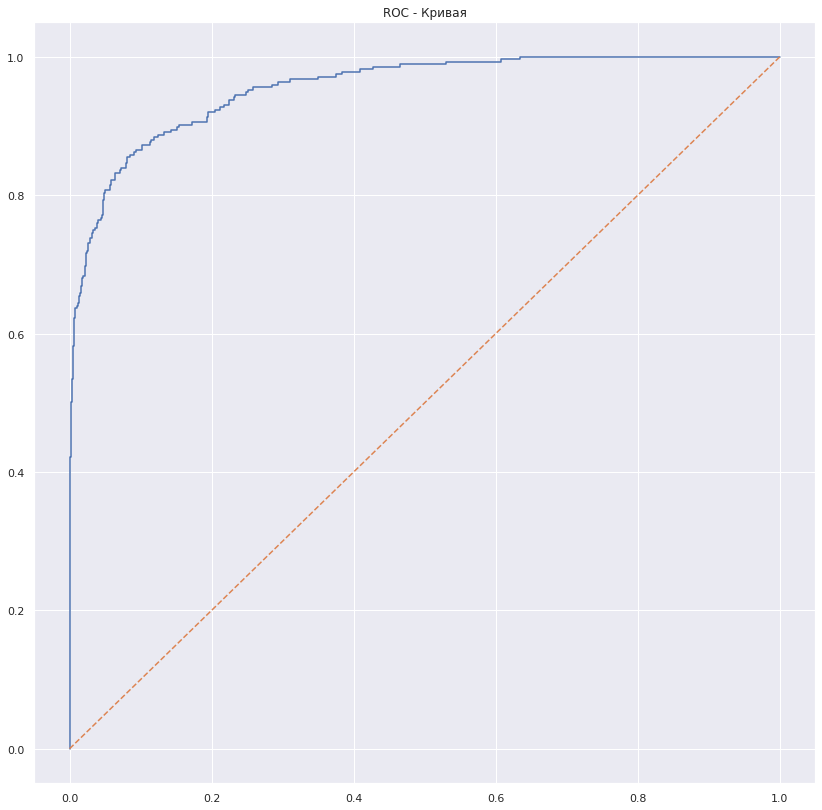

In [102]:
fpr, tpr, thresholds = roc_curve(y_test, pred)

plt.title('ROC - Кривая')
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')

plt.show()


In [104]:
# матрица ошибок
conf_matrix = confusion_matrix(y_test, pred_ac)
print(conf_matrix)

[[1352  134]
 [  39  236]]


Из матрицы ошибок можно сделать вывод, что:  
количество верных положительных предсказаний - 1352,  
количество верных отрицательных предсказаний - 236,  
количество ошибочно положительных предсказаний - 134,  
а количество ошибочно отрицательных предсказаний - 236  

Итак, на тестовых данных модель показала ROC-AUC примерно 0.96, что удовлетворяет условиям задачи (>0.85). Также модель показала хорошую точность - 0.91.  
Таким образом, данная модель подходит для предсказания оттока клиентов.  
Гиперпараметры для модели:  
'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1600


## Важность признаков

Посмотрим на важность признаков.

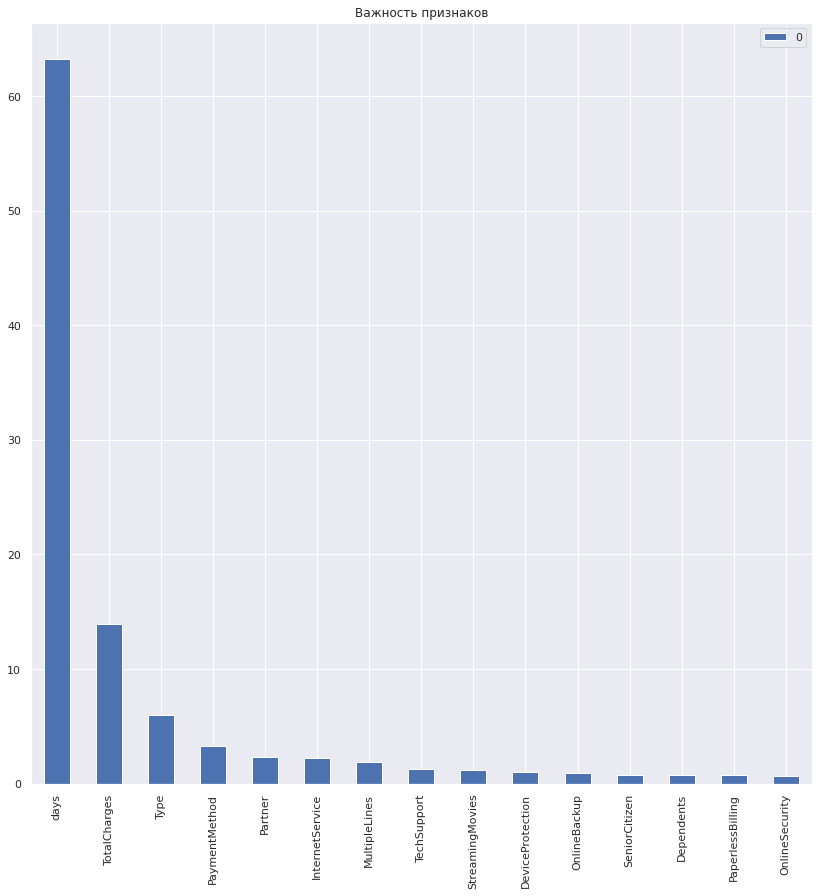

In [105]:
important_features = pd.DataFrame(search.best_estimator_.feature_importances_, index = X_test.columns).sort_values(by=0, ascending=False).plot(kind='bar', title='Важность признаков')

Таким образом, самыми важными признаками стали: количество дней обслуживания клиента и траты за весь период.

# Выводы

Исходя из исследования мы можем сделать следующие выводы.

Данные необходимо было предобработать. Мы заполнили пропуски, убрали лишние признаки, такие как MonthlyCharges (вызывал мультиколлениарность) и gender (т.к. он никак не влиял на целевой признак), также удалили выбросы по столбцу TotalCharges.

Мы выявили, что в среднем ушедшие клиенты обслуживались дольше, чем оставшиеся. Больше людей предпочитает оплату электронными чеками, а также редко пользуются услугами защиты устройства. Ушедшие клиенты обслуживались дольше, при этом наблюдается большое количество клиентов, у которых суммарные затраты в районе 0, это связано с тем, что новых клиентов достаточно много.

Мы использовали 3 модели для предсказания оттока клиентов: CatBoost Classifier, RandomForst Classifier и Logistic Regression.  
По результатам обучения и тестирования мы можем сказать, что наиболее подходящей моделью для предсказания оттка клиентов является CatBoost Classifier ('learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1600), т.к. на тестовых данных она показала очень хороший результат AUC_ROC (примерно 0.96), а точность модели примерно 0.9, что удовлетворяет условиям заказчика. RandomForest Classifier Показал результаты хуже, чем CatBoost, а LogisticRegression оказалась, скажем так на третьем месте.

Также мы провели исследование на важность признаков.  
Оказалось, что общее количество дней обслуживания клиентов и общие траты за все время обслуживания являются наиболее важными признаками.  
Далее идут тип договора и метод оплаты.

# Отчет

При выполнении проекта все пункты плана были выполнены.  
Ключевыми шагами выполнения задачи стали:  
1. подготовка данных (например, удаление некоторых признаков и добавление нового, замена неявных пропусков);
2. обработка категориальных признаков (кодирование и масштабирование);
3. подбор гиперпараметров для моделей, с целью улучшения результатов обучения.  
  
В ходе исследования были использованы следующие признаки: общее количество дней обслуживания клиента, общие траты клиента, тип договора, метод оплаты, наличеие супруга(и), пользование интернет услугами, несколькими линиями телефонной связи, техподдержкой и т.д.  
При этом были удалены месячные траты клиента, т.к. данный признак сильно коррелировал с другими, а также гендер, т.к. данный признак никак не влиял на отток клиентов.  
Был добавлен новый признак - общее количество дней обслуживания клиента, после чего были удалены даты начала и окончания действия договора, т.к. они бы мешали обучению.  Также мы удалили признак Онлайн ТВ, т.к. он сильно коррелировал с другим признаком.  
  
В ходе предобработки данных были найдены неявные пропуски в признаке общих трат. Мы выяснили, что они были связаны с тем, что клиент заключил договор в день выгрузки данных. Поэтому было принято решение заменить их на соответсвующие месячные траты, т.к. оплата уже была произведена. Также в данных даты окончания договора было много значений 'No', их мы заменили на дату выгрузки данных.  
  
Для исследования были выбраны следующие модели: CatBoost Classifier, RandomForest Classifier и Logistic Regresson.  
По результатам обучения моделей были достигнуты следующие результаты:

| Модель | ROC-AUC |
| :- | -: |
| CatBoost Classifier | 0.91 |
| RandomForest Classifier | 0.81 |
| Logistic Regression | 0.75 |
  
Таким образом мы выбрали CatBoost Classifier, т.к. данная модель показала лучший результат на тренировочных данных.  
CatBoost Classifier - это модель градиентного бустинга на решающих деревьях, которая может решать задачи классификации. Она может сама бороться с несбалансированными данными, а также работать с категориальными признаками, при этом имеет более высокое качество по сравнению с другими моделями.  
Основными параметрами данной модели выступают:  
количество итераций;  
коэффициент скорости обучения;  
глубина деревьев;  
количество деревьев и т.д.  
  
В результате обучения лучшими параметрами оказались:  
коэффициент скорости обучения - 0.1;
глубина деревьев - 3;
количество деревьев - 1600.  
  
При тестировании данной модели с выбранными параметрами мы добились слежующих результатов:  
1. ROC-AUC - 0.96;
2. Точность модели - 0.9.
  
Таким образом на тестовых данных модель правильно предсказала 1588 значений, а ложных предсказаний получилось 370, что является хорошим результатом.  
  
Также мы провели исследование важности признаков.  В результате можно сделать вывод, что основными признаками являются количество дней обслуживания клиента, общие расходы клиента и тип договора, но так или иначе наиболее сильным признаком является первый из перечисленных.  
